<a href="https://colab.research.google.com/github/Kyrylog/training/blob/main/Copy_of_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 376 kB 25.9 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=8f055766128edb6075acba5a9668382a8351ac0709e198747d77289a8b85f84e
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=496a3071338ad72550d5dff592a5ec6a0f2c0ad270e17df87a1bbe6389c8b5cd
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-cey6qurd
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-cey6qurd
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [3]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 11.98 MiB/s, done.
Resolving deltas: 100% (3/3), done.


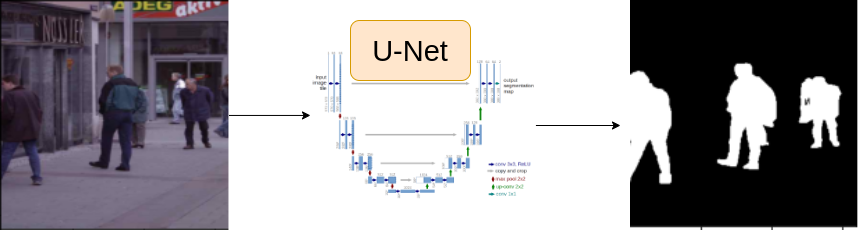

# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'
DEVICE ='cuda'
EPOCHS = 25
LR = 0.003 #learining rate
IMG_SIZE = 320
BATCH_SIZE = 16
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'
df = pd.read_csv(CSV_FILE)
df.head()


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [29]:
row = df.iloc[23]
image_path = row.images
mask_path = row.masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

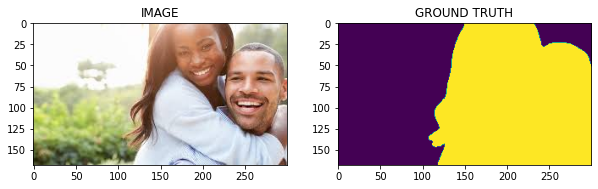

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask) #,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A 

def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
   return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)    
  ])

# Task 4 : Create Custom Dataset 

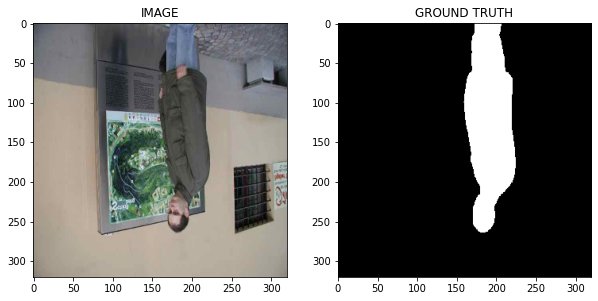

In [11]:
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
  
  def __init__(self, df, augmentations):
    
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]
    
    image_path = row.images
    mask_path = row.masks
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # h = height w = weight c = channel  
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

idx =34
image, mask = trainset[idx]
helper.show_image(image, mask)



In [12]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


# Task 5 : Load dataset into batches

In [13]:
from torch.utils.data import DataLoader


In [14]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [15]:
print(len(trainloader))
print(len(validloader))

15
4


In [16]:
for image, mask in trainloader:
  break

print(image.shape)
print(mask.shape)

torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [18]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks!=None:
      loss1 = DiceLoss(mode='binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1 + loss2
    return logits
    
      
    


In [ ]:
model = SegmentationModel()
model.to(DEVICE)

# Task 7 : Create Train and Validation Function 

In [20]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0
  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss / len(data_loader)



In [21]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
    # optimizer.zero_grade()
      logits, loss = model(images, masks)
    # loss.backward()
      #optimizer.step()
      total_loss += loss.item()

  return total_loss / len(data_loader)


# Task 8 : Train Model

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss=eval_fn(validloader, model)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED-MODEL')
    best_valid_loss=valid_loss
  print(f'Epoch: {i+1} Train loss: {train_loss} Valid loss: {valid_loss}')


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


SAVED-MODEL
Epoch: 1 Train loss: 0.7312147994836171 Valid loss: 0.7201496213674545


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


SAVED-MODEL
Epoch: 2 Train loss: 0.3872193217277527 Valid loss: 0.3513505235314369


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


SAVED-MODEL
Epoch: 3 Train loss: 0.3035691996415456 Valid loss: 0.2607911005616188


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


SAVED-MODEL
Epoch: 4 Train loss: 0.25356291731198627 Valid loss: 0.22915044054389


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch: 5 Train loss: 0.2601569155852 Valid loss: 0.23634161427617073


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epoch: 6 Train loss: 0.2044361064831416 Valid loss: 0.2609668895602226


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch: 7 Train loss: 0.22032478352387747 Valid loss: 0.24673112481832504


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


SAVED-MODEL
Epoch: 8 Train loss: 0.21373391499121983 Valid loss: 0.22336997464299202


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


SAVED-MODEL
Epoch: 9 Train loss: 0.1859876056512197 Valid loss: 0.21298740431666374


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


SAVED-MODEL
Epoch: 10 Train loss: 0.2097990483045578 Valid loss: 0.18203160911798477


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch: 11 Train loss: 0.16564538677533466 Valid loss: 0.20614687725901604


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


SAVED-MODEL
Epoch: 12 Train loss: 0.14077291886011759 Valid loss: 0.17977262288331985


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch: 13 Train loss: 0.14415643562873204 Valid loss: 0.20001546293497086


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch: 14 Train loss: 0.1505642722050349 Valid loss: 0.2512870319187641


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epoch: 15 Train loss: 0.15281908214092255 Valid loss: 0.2007054127752781


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch: 16 Train loss: 0.15404833058516185 Valid loss: 0.22675485908985138


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epoch: 17 Train loss: 0.13519228249788284 Valid loss: 0.25020448863506317


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epoch: 18 Train loss: 0.144925053914388 Valid loss: 0.21477752551436424


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch: 19 Train loss: 0.139933443069458 Valid loss: 0.21447860822081566


100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


Epoch: 20 Train loss: 0.1436224326491356 Valid loss: 0.2666834071278572


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch: 21 Train loss: 0.14666267136732739 Valid loss: 0.21210088580846786


100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


Epoch: 22 Train loss: 0.11114119589328766 Valid loss: 0.1836516633629799


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


Epoch: 23 Train loss: 0.11847797383864721 Valid loss: 0.22143590822815895


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch: 24 Train loss: 0.12330971856911978 Valid loss: 0.18237678334116936


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

Epoch: 25 Train loss: 0.11170609891414643 Valid loss: 0.18226945027709007


# Task 9 : Inference

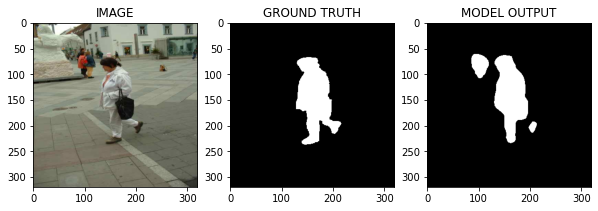

In [35]:
idx = 40
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE). unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5) * 1.0 

helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))


# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya